# Recommender Systems 2019/20

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [61]:
from urllib.request import urlretrieve
import zipfile

# skip the download
# urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "data/Movielens_10M/movielens_10m.zip")
dataFile = zipfile.ZipFile("data/Movielens_10M/movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = "data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)


In [62]:
def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

    
    
list_ID_stats(userList, "User")
list_ID_stats(itemList, "Item")

User data, ID: min 1, max 71567, unique 69878, missig 2.36 %
Item data, ID: min 1, max 65133, unique 10677, missig 83.61 %


### For items in particular most have no interactions. Sometimes it may be better to remove them to avoid creating big data structures with no need. In this case empty columns will nave no impact and we leave them as is. 

## And now load the content informations in the same way:
## In this case we are using tags

In [63]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)


In [64]:
list_ID_stats(userList_icm, "Users ICM")
list_ID_stats(itemList_icm, "Items ICM")

Users ICM data, ID: min 15, max 71556, unique 4009, missig 94.40 %
Items ICM data, ID: min 1, max 65130, unique 7601, missig 88.33 %


### We can see that most users and items have no data associated to them

In [65]:
numTags = len(set(tagList_icm))

print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])

Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [66]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

#### Be careful with the indices!

In [67]:
import numpy as np

n_items = URM_all.shape[1]
n_tags = max(tagList_icm) + 1

ICM_shape = (n_items, n_tags)

ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape = ICM_shape)
ICM_all = ICM_all.tocsr()

ICM_all

<65134x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [68]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [69]:
print(features_per_item.shape)
print(items_per_feature.shape)

(65134,)
(16529,)


In [70]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

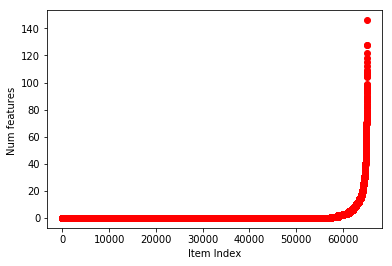

In [71]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

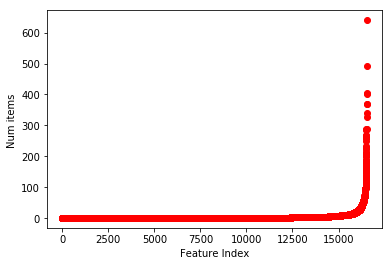

In [72]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [73]:
from Notebooks_utils.data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)


from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python


In [74]:
class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

## Test our CBF recommender:

In [75]:
recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 38000 ( 58 % ), 1266.55 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1249.02 column/sec, elapsed time 0.87 min


In [76]:
for user_id in userList_unique[0:10]:
    print(recommender.recommend(user_id, at=5))

[8636 6333  153  592 2640]
[1210 1370  153  181  316]
[65133 21706 21719 21718 21717]
[ 1591  5618   153  6350 51939]
[8525 2566 1026 5651 2043]
[65133 21706 21719 21718 21717]
[65133 21706 21719 21718 21717]
[ 4239  1196  5378 33493  3114]
[2628 8984 4993  260 5378]
[65133 21706 21719 21718 21717]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [77]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 453.90 usr/sec


### Let's add a common mistake.... a CSC URM

In [78]:
URM_train_csc = URM_train.tocsc()

recommender = ItemCBFKNNRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 36800 ( 56 % ), 1226.43 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1228.23 column/sec, elapsed time 0.88 min


In [79]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 65135 is out of bounds for axis 0 with size 65134


Traceback (most recent call last):
  File "<ipython-input-79-cd8883de5544>", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "<ipython-input-74-d625b194ca44>", line 23, in recommend
    scores = self.filter_seen(user_id, scores)
  File "<ipython-input-74-d625b194ca44>", line 38, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 65135 is out of bounds for axis 0 with size 65134


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [80]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 35000 ( 54 % ), 1164.81 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1164.12 column/sec, elapsed time 0.93 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0930, Recall = 0.0208, MAP = 0.0616
Similarity column 34300 ( 53 % ), 1141.71 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1180.09 column/sec, elapsed time 0.92 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0777, Recall = 0.0171, MAP = 0.0546
Similarity column 34900 ( 54 % ), 1163.23 column/sec, elapsed time

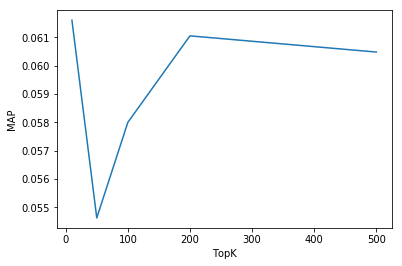

In [81]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [82]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 35300 ( 54 % ), 1175.38 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1188.52 column/sec, elapsed time 0.91 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0827, Recall = 0.0183, MAP = 0.0580
Similarity column 35400 ( 54 % ), 1178.20 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1126.17 column/sec, elapsed time 0.96 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1204, Recall = 0.0257, MAP = 0.0872
Similarity column 35000 ( 54 % ), 1164.54 column/sec, elapsed time

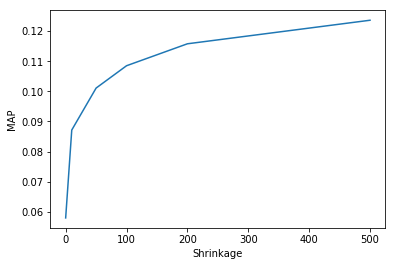

In [83]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

In [84]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(65134, 16529)
(16529,)


In [85]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(16529,)
(65134, 16529)
(16529,)


In [86]:
recommender_idf = ItemCBFKNNRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

evaluate_algorithm(URM_test, recommender_idf)

Similarity column 31000 ( 48 % ), 1031.07 column/sec, elapsed time 0.50 min
Similarity column 63300 ( 97 % ), 1053.13 column/sec, elapsed time 1.00 min
Similarity column 65100 ( 100 % ), 1054.02 column/sec, elapsed time 1.03 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0796, Recall = 0.0175, MAP = 0.0559


{'precision': 0.07963501453923623,
 'recall': 0.017463794799541972,
 'MAP': 0.05587112584931138}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# Unnormalized similarity matrix

In [87]:

recommender_dot = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

evaluate_algorithm(URM_test, recommender_dot)

Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1746, Recall = 0.0367, MAP = 0.1339


{'precision': 0.17463150506369093,
 'recall': 0.03668755244512849,
 'MAP': 0.1339324947198847}